In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sys
sys.path.append('../src')
from utils.load_data import load_metadata, load_trial
from preprocessing.preprocessing import preprocess_deep_learning

In [2]:
base_path = '../data'
metadata = load_metadata(base_path)
train_df = metadata['train']
validation_df = metadata['validation']
test_df = metadata['test']
train_df.head()

,id,subject_id,task,trial_session,trial,label
0,1,S1,MI,1,1,Left
1,2,S1,MI,1,2,Right
2,3,S1,MI,1,3,Left
3,4,S1,MI,1,4,Left
4,5,S1,MI,1,5,Left


In [3]:
target_len = 500  # fixed time length
n_channels = 8    # fixed number of EEG channels (if known; adjust if needed)

train_s1_df = train_df[train_df['subject_id'] == 'S1']

train_trials, train_labels = [], []

for idx, row in train_s1_df.iterrows():
    trial = load_trial(row, 'train', base_path)  # shape: (n_channels, n_times) or (n_times, n_channels)

    if trial.shape[0] < 30:
        continue

    processed, _ = preprocess_deep_learning(trial)

    # Ensure processed shape: (n_channels, n_times)
    if processed.shape[0] != n_channels:
        processed = processed.T  # transpose if needed

    # Pad or trim to fixed length
    n_t = processed.shape[1]
    if n_t < target_len:
        processed = np.pad(processed, ((0, 0), (0, target_len - n_t)), mode='constant')
    else:
        processed = processed[:, :target_len]

    # At this point, shape must be (n_channels, target_len)
    processed_flat = processed.reshape(-1)  # flatten to (n_channels * target_len,)
    train_trials.append(processed_flat)
    train_labels.append(row['label'])

# Final conversion
X_train = np.stack(train_trials)  # shape: (n_samples, n_channels * target_len)
y_train = LabelEncoder().fit_transform(train_labels)

print(f'S1 Training shape: {X_train.shape}, Labels: {np.unique(y_train)}')

S1 Training shape: (160, 9000), Labels: [0 1 2 3]


In [4]:
target_len = 500   # same as used in training
n_channels = 8     # adjust if different in your dataset

val_trials, val_labels = [], []

for idx, row in validation_df.iterrows():
    trial = load_trial(row, 'validation', base_path)  # shape: (n_channels, n_times) or (n_times, n_channels)

    if trial.shape[0] < 30:
        print(f"Skipping trial {row['id']} due to insufficient length: {trial.shape[0]}")
        continue

    processed, _ = preprocess_deep_learning(trial)

    # Ensure shape is (n_channels, n_times)
    if processed.shape[0] != n_channels:
        processed = processed.T  # transpose if needed

    # Pad or trim to target_len
    n_t = processed.shape[1]
    if n_t < target_len:
        processed = np.pad(processed, ((0, 0), (0, target_len - n_t)), mode='constant')
    else:
        processed = processed[:, :target_len]

    # Flatten to 1D
    processed_flat = processed.reshape(-1)
    val_trials.append(processed_flat)
    val_labels.append(row['label'])

# Final conversion
X_val = np.stack(val_trials)  # shape: (n_samples, n_channels * target_len)
y_val = LabelEncoder().fit_transform(val_labels)

print(f'Validation shape: {X_val.shape}, Labels: {np.unique(y_val)}')

Validation shape: (100, 9000), Labels: [0 1 2 3]


SVM Accuracy: 0.41
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        12
           2       0.43      0.88      0.57        42
           3       0.31      0.12      0.18        32

    accuracy                           0.41       100
   macro avg       0.18      0.25      0.19       100
weighted avg       0.28      0.41      0.30       100



d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


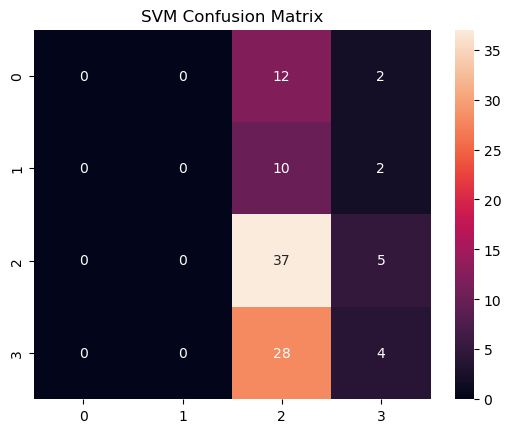

In [5]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_val)
print("SVM Accuracy:", accuracy_score(y_val, svm_preds))
print("Classification Report:\n", classification_report(y_val, svm_preds))
sns.heatmap(confusion_matrix(y_val, svm_preds), annot=True, fmt='d')
plt.title("SVM Confusion Matrix")
plt.show()


### Hybrid ELM model

In [ ]:
# Placeholder: Add Hybrid ELM model here
# Example:
# elm_model = HybridELM(...)
# elm_model.fit(X_train, y_train)
# elm_preds = elm_model.predict(aX_val)
# print("ELM Accuracy:", accuracy_score(y_val, elm_preds))


In [6]:
import numpy.linalg as LA

class ELMClassifier:
    def __init__(self, n_hidden=1000, activation='sigmoid'):
        self.n_hidden = n_hidden
        self.activation = activation

    def _activate(self, X):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-X))
        elif self.activation == 'tanh':
            return np.tanh(X)
        else:
            raise ValueError("Unsupported activation")

    def fit(self, X, y):
        self.input_weights = np.random.randn(X.shape[1], self.n_hidden)
        self.biases = np.random.randn(self.n_hidden)

        H = self._activate(np.dot(X, self.input_weights) + self.biases)
        self.output_weights = np.dot(LA.pinv(H), y)

    def predict(self, X):
        H = self._activate(np.dot(X, self.input_weights) + self.biases)
        raw_outputs = np.dot(H, self.output_weights)
        return np.round(raw_outputs).astype(int)


ELM Accuracy: 0.21
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.14      0.18        14
           1       0.05      0.08      0.06        12
           2       0.38      0.29      0.32        42
           3       0.23      0.19      0.21        32
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.21       100
   macro avg       0.15      0.12      0.13       100
weighted avg       0.27      0.21      0.24       100



d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


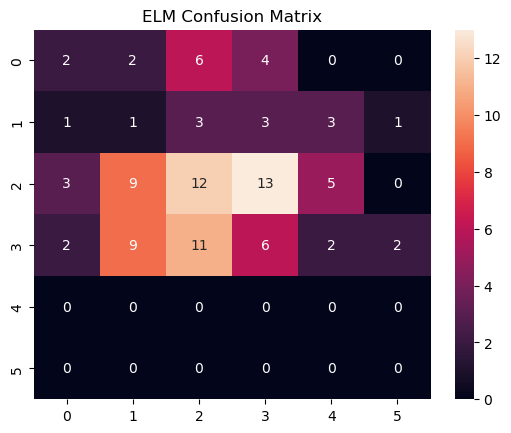

In [7]:
elm = ELMClassifier(n_hidden=1000, activation='sigmoid')
elm.fit(X_train, y_train)
elm_preds = elm.predict(X_val)

print("ELM Accuracy:", accuracy_score(y_val, elm_preds))
print("Classification Report:\n", classification_report(y_val, elm_preds))
sns.heatmap(confusion_matrix(y_val, elm_preds), annot=True, fmt='d')
plt.title("ELM Confusion Matrix")
plt.show()


Hybrid ELM + SVM Accuracy: 0.4
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        12
           2       0.43      0.90      0.58        42
           3       0.18      0.06      0.09        32

    accuracy                           0.40       100
   macro avg       0.15      0.24      0.17       100
weighted avg       0.24      0.40      0.27       100



d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


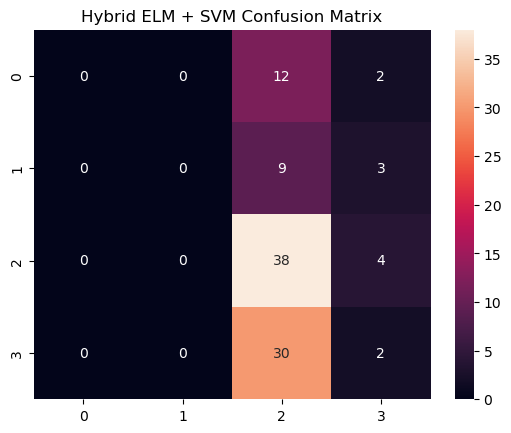

In [8]:
# Hybrid ELM + SVM: Use ELM hidden layer as features for SVM
H_train = 1 / (1 + np.exp(-(np.dot(X_train, elm.input_weights) + elm.biases)))
H_val = 1 / (1 + np.exp(-(np.dot(X_val, elm.input_weights) + elm.biases)))

hybrid_svm = SVC(kernel='rbf')
hybrid_svm.fit(H_train, y_train)
hybrid_preds = hybrid_svm.predict(H_val)

print("Hybrid ELM + SVM Accuracy:", accuracy_score(y_val, hybrid_preds))
print("Classification Report:\n", classification_report(y_val, hybrid_preds))
sns.heatmap(confusion_matrix(y_val, hybrid_preds), annot=True, fmt='d')
plt.title("Hybrid ELM + SVM Confusion Matrix")
plt.show()


MLP Accuracy: 0.34
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.14      0.18        14
           1       0.50      0.25      0.33        12
           2       0.38      0.24      0.29        42
           3       0.32      0.59      0.41        32

    accuracy                           0.34       100
   macro avg       0.36      0.31      0.31       100
weighted avg       0.36      0.34      0.32       100



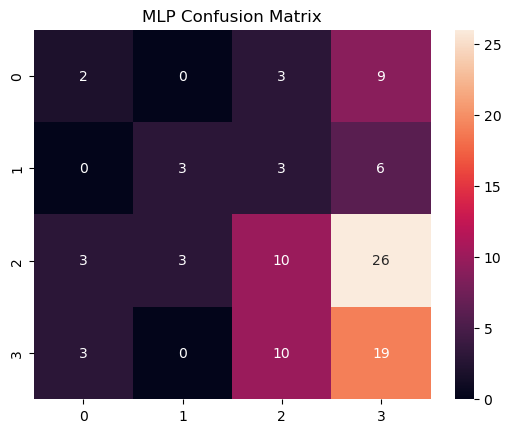

In [9]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_val)

print("MLP Accuracy:", accuracy_score(y_val, mlp_preds))
print("Classification Report:\n", classification_report(y_val, mlp_preds))
sns.heatmap(confusion_matrix(y_val, mlp_preds), annot=True, fmt='d')
plt.title("MLP Confusion Matrix")
plt.show()
